# Text classification with TensorFlow and word embeddings

## Evolution of word representations

Classification of text documents is an important [NLP task](http://nlpprogress.com/), and NLP is one of the fastest-growing domains in Deep Learning.  To understand words, a computer needs to receive not the words as they are, but a vector of numbers it can compute over to solve a specific problem.  
Indeed NLP refers to a set of techniques involving the application of statistical methods to understand text for the sake of solving real-world tasks.  

This “understanding” of text is mainly derived by transforming texts into useable computational representations as vectors or tensors, graphs, and trees.


Those representations have evolved during the last 30 years and particularly fast in the last ten years. 

Initial techniques like [Bag of Words (BoW)](https://en.wikipedia.org/wiki/Bag-of-words_model) or Or [TF-IDF (Term Frequency Inverse Document Frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) do not take into account any relationship between words. They add a mathematical approach to text but could be used at document level simple tasks like document similarity, document sentiment, etc. 

For a more in-depth analysis of a text, we need to come up with a numerical representation of each word. Probably you are familiar with One-hot encoding, but using it with a large vocabulary is not very helpful. 

[Word embeddings](https://ronxin.github.io/wevi/) try to learn the statistical structure of written language and use geometric relationships between vectors as equivalent to the semantic relations of words, with great success. 

![embeddings](images/embeddings.png)


> A classical example demonstrating the value of word embeddings: if we subtract the vector Man to the vector King and then we add the vector Woman, the result is the vector Queen.  

While TF-IDF is an example of count-based word embeddings (they are not learned from the data but heuristically constructed, word embeddings as implemented by [Word2Vec](https://arxiv.org/abs/1301.3781) or [Glove](https://nlp.stanford.edu/projects/glove/), for example, are learned embeddings or prediction-based.  

This opens the door to the use of pre-trained embeddings (using large corpora like Google News, Wikipedia, or Common Crawl) that extract features from the input (as convolutions in computer vision) and achieve excellent results with a small volume of annotated text, thanks to transfer-learning-based techniques. Then, we don’t train embeddings from scratch, we classify our data using transfer learning. 

## Project background

A company is using commercial software for this classifying news mentioning the brand, both on the Internet and social networks. Results are weak, so they wanted to test the possibilities of an in house development. The problem is that de the Marketing department doesn’t want to invest in manual manipulation of the mentions, as that’s what the PR team is obligated to do now.

We are asked to demonstrate that an efficient model could be trained without too many efforts in tagging results manually, even for the creation of the initial training dataset. If results are good and automation is possible, we will then implement the solution in production environment.

## Project goals

- Design, test and evaluate at least four different models for document classification
- Demonstrate easiness in the application of models to business tasks
- Demonstrate a minimum level of accuracy
- Select a model for implementation
- To test and evaluate our models, we will use a labeled data dataset so we can classify each text entry in one of these categories: business, entertainment, politics, sport, tech.

The categories provided by the data set are very generic, and in some cases, could be estimated based on some kind of metadata captured with the text document when working in real-life scenarios. But the final goal is not to maintain these categories once a model is moved into production. Nor is it to use this very same dataset at its labels.

Our goal at this stage is to demonstrate it is possible to get satisfactory results when training a model with a relatively small training dataset. If this hypotesis is true, a new training dataset would be created with more relevant labels, but a similar number of cases as our input.

What the company is asking us to do is to invest little in manual labeling, but they are not assuming that some labeling should be done.
Based on this perspective, the company has defined the following **acceptance criteria**:

 - Time for model development less than 5 weeks 
 - Accuracy of the model over 90% 
 - Applicability to both long and short texts 
 - No manual tagging or at last no more than one person dedicated to that during the 5 weeks of development 


![workflow](images/workflow.jpg)

## Project workflow

1. Data loading 
2. Data Exploration
3. Tokenization 
4. Word encoding 
5. Model design and evaluation
6. Benchmark
7. Recommendations

In this notebook, we will cover all these steps, but we are not covering the implementation of the recommended solution that would be developed in a separate environment. 



## Step 0. Libraries and hyperparameters

In [24]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

import tweepy
print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2.2.0-rc3


After importing the necessary libraries we are using for the project, we define the hyper parameters in a single cell for better adjustment in case we need to modify later

In [0]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

## Step 1. Load the data

### The BBC news dataset

We will use the BBC news dataset, which consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005. Class Labels: 5 (business, entertainment, politics, sport, tech)

This dataset is publicly available and relatively small, meaning if our results meet the company expectations, we will demonstrate that it could be possible, even with a small number of pre-classified documents.


In [26]:
import csv 
articles = []
labels = []

with open("data/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print("Number of Labels:{}".format(len(labels)))
print("Number of Articles:{}".format(len(articles)))

Number of Labels:2225
Number of Articles:2225


The BBC dataset consists of two columns we import into separate lists (articles and labels) Labels will contain the categories used to classify each text.

## Step 2: Data exploration  

To train our model is essential to understand the distribution of our data. As we are working with text, there is not too many statistics to look at, but one important thing: is the dataset balanced or imbalanced? If the number of cases for each label is imbalanced, it could lead to mismatched learnings as the model interprets that some features are more common in the data than others. Although results during training could be fine when dealing with real-world data, it could become a problem. 

In [27]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

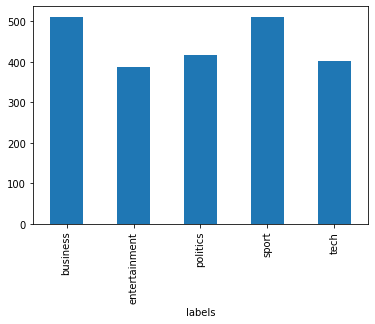

In [28]:
df.groupby('labels').labels.count().plot.bar(ylim=0)

There are 2,225 news articles in the data, and labels are quite balanced. We split them into a training set and validation set, according to the parameter we set earlier, 80% for training, 20% for validation.

In [29]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


## Step 3. Tokenization

The tokenizer will handle the heavy lifting for us, generating the dictionary of word encodings and creating vectors out of the sentences. The first parameter demands the number of words we want to include in our dictionary and the token we want to use in case our data contains a word that it's not included in it. oov stands for Out of Vocabulary, and we'll use the common OOV defined in our hyperparameter section. You usually don't know how many unique distinct words there are in the text. So by setting this hyperparameter, what the tokenizer will do is take the top 5000 words by volume and encode those.

The fit on the text method of the tokenizer then takes in the data and encodes it. The tokenizer provides a word index property that returns a dictionary containing key-value pairs, where the key is the word, and the value is the token for that word, which you can inspect by directly printing it out.

In [30]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'also': 6,
 'mr': 3,
 'new': 8,
 'one': 10,
 'people': 7,
 'said': 2,
 'us': 9,
 'would': 4,
 'year': 5}

### Sequences
The next step will be to turn your sentences into lists of values based on these tokens. Once you have them, you'll likely also need to manipulate these lists, not least to make every sentence the same length; otherwise, it may be hard to train a neural network with them.

In [31]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2432, 1, 225, 4996, 22, 642, 587, 225, 4996, 1, 1, 1663, 1, 1, 2432, 22, 565, 1, 1, 140, 278, 1, 140, 278, 796, 822, 662, 2308, 1, 1144, 1694, 1, 1721, 4997, 1, 1, 1, 1, 1, 4738, 1, 1, 122, 4515, 1, 2, 2874, 1506, 352, 4739, 1, 52, 341, 1, 352, 2173, 3961, 41, 22, 3793, 1, 1, 1, 1, 543, 1, 1, 1, 835, 631, 2367, 347, 4740, 1, 365, 22, 1, 787, 2368, 1, 4302, 138, 10, 1, 3664, 682, 3531, 1, 22, 1, 414, 822, 662, 1, 90, 13, 633, 1, 225, 4996, 1, 600, 1, 1694, 1021, 1, 4998, 807, 1864, 117, 1, 1, 1, 2974, 22, 1, 99, 278, 1, 1608, 4999, 543, 492, 1, 1444, 4741, 778, 1320, 1, 1861, 10, 33, 642, 319, 1, 62, 478, 565, 301, 1507, 22, 479, 1, 1, 1666, 1, 797, 1, 3067, 1, 1365, 6, 1, 2432, 565, 22, 2971, 4735, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1507, 1343, 374, 20, 63, 883, 1096, 4303, 247]


### Padding 
Once the tokenizer has created the sequences, these sequences can be passed to pad sequences to have them padded. The result is that the list of sentences has been padded out into a matrix and that each row in the matrix has the same length. The parameters trunc_type = 'post' and padding_type = 'post' defines that the extra number of zeros added to convert all sentences to the same length, will appear after the sentence and not before.

In [32]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

425
200
192
200
186
200


In [33]:
print(train_padded[10])

[2432    1  225 4996   22  642  587  225 4996    1    1 1663    1    1
 2432   22  565    1    1  140  278    1  140  278  796  822  662 2308
    1 1144 1694    1 1721 4997    1    1    1    1    1 4738    1    1
  122 4515    1    2 2874 1506  352 4739    1   52  341    1  352 2173
 3961   41   22 3793    1    1    1    1  543    1    1    1  835  631
 2367  347 4740    1  365   22    1  787 2368    1 4302  138   10    1
 3664  682 3531    1   22    1  414  822  662    1   90   13  633    1
  225 4996    1  600    1 1694 1021    1 4998  807 1864  117    1    1
    1 2974   22    1   99  278    1 1608 4999  543  492    1 1444 4741
  778 1320    1 1861   10   33  642  319    1   62  478  565  301 1507
   22  479    1    1 1666    1  797    1 3067    1 1365    6    1 2432
  565   22 2971 4735    1    1    1    1    1  850   39 1825  675  297
   26  979    1  882   22  361   22   13  301 1507 1343  374   20   63
  883 1096 4303  247    0    0    0    0    0    0    0    0    0    0
    0 

We do the same with validation segment and of course with labels

In [34]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


In [35]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


## Step 4: Word encoding.

![word2vec](images/word2vec.png)

Word Embeddings encode the relationships between words through vector representations of the words. These word vectors are analogous to the meaning of the word, but the limitation of word embeddings are that must have been seen in the training data before, to have an embedding.  

As an example, this text contains several OOV tokens where our dictionary didn't find an equivalent.
Of course, you can create a more significant dictionary, but taking into account that sometimes the impact of fewer words can be minimal in training accuracy, but huge in training time. We can experiment but using it carefully.  

For this project, we will use the same vocab_size in all the models, while testing the effect of pre-trained embeddings, as we will see soon. 

In [36]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest intense trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film en

## Step 5. Model design

## Model 1 - Bidirectional LSTM + embedding

Dense layers treat each word in the input sequence separately, without considering inter-word relationships and sentence structure. It's much better to add recurrent layers or 1D convolutional layers on top of the embedded sequences to learn features that take into account each sequence as a whole.

**LSTM** ([Long Short-Term Memory](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)) is a type of recurrent layer frequently used in models with sequence data (as text). They provide enough "memory" for the task, without incurring in the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) as simple RNNs. 

**Bidirectional** layers increase the effectiveness of LSTM, propagating the input forward and backward through the LSTM layer and then concatenating the outputs.

**Word embeddings** are meant to map human language into a geometric space. The geometric relationships between word vectors should reflect the semantic relationships between these words, and those relationships are learned in the same way it learns the weights of the neural network.

So, our baseline model will be this and will test other architectures while keeping the **activation function** as softmax, because we are using a multiclass classification and **Loss function** as sparse_categorical_crossentropy instead of categorical_crossentropy as we use integer labels.


  
   

In [37]:
LSTM = tf.keras.Sequential([
    # Add an Embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    #Bidirectional and LSTM 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2)),
    # use ReLU as activation
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [38]:
LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = LSTM.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 1.5797 - accuracy: 0.3112 - val_loss: 1.3442 - val_accuracy: 0.4809
Epoch 2/10
56/56 - 1s - loss: 1.0603 - accuracy: 0.5787 - val_loss: 0.8063 - val_accuracy: 0.6652
Epoch 3/10
56/56 - 1s - loss: 0.7203 - accuracy: 0.7320 - val_loss: 0.4838 - val_accuracy: 0.8404
Epoch 4/10
56/56 - 1s - loss: 0.2678 - accuracy: 0.9225 - val_loss: 0.2185 - val_accuracy: 0.9303
Epoch 5/10
56/56 - 1s - loss: 0.1103 - accuracy: 0.9691 - val_loss: 0.3975 - val_accuracy: 0.8831
Epoch 6/10
56/56 - 1s - loss: 0.0434 - accuracy: 0.9916 - val_loss: 0.2110 - val_accuracy: 0.9393
Epoch 7/10
56/56 - 1s - loss: 0.0169 - accuracy: 0.9961 - val_loss: 0.1498 - val_accuracy: 0.9596
Epoch 8/10
56/56 - 1s - loss: 0.0090 - accuracy: 0.9978 - val_loss: 0.1769 - val_accuracy: 0.9573
Epoch 9/10
56/56 - 1s - loss: 0.0257 - accuracy: 0.9933 - val_loss: 0.2926 - val_accuracy: 0.9213
Epoch 10/10
56/56 - 1s - loss: 0.0143 - accuracy: 0.9972 - val_loss: 0.1684 - val_accuracy: 0.9551


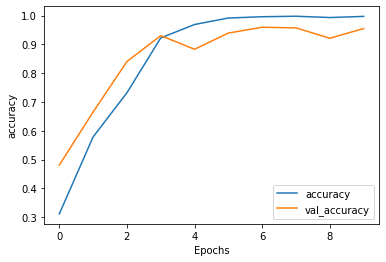

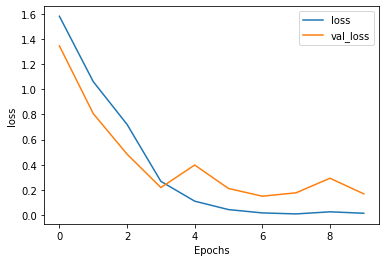

In [39]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The model quickly starts overfitting, and validation accuracy has a high variance for the same reason, but even then, we got to 93%. We probably don't need more than 3-4 epochs to get satisfactory results

## Model 2 - Conv1D + Pooling + Embedding

Now we try with convolutions. 1D convolution layers can recognize local patterns in a sequence. It should be able to learn words or word fragments and recognize these words in any context in an input sequence. 



In [40]:
# Model Definition with Conv1D
CONV1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2)),
    tf.keras.layers.Dense(6, activation='softmax')
])
CONV1D.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
CONV1D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         41088     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 460,678
Trainable params: 460,678
Non-trainable params: 0
_________________________________________________________________


In [41]:
CONV1D.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = CONV1D.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 1.4811 - accuracy: 0.3449 - val_loss: 1.0442 - val_accuracy: 0.5461
Epoch 2/10
56/56 - 1s - loss: 0.5879 - accuracy: 0.7938 - val_loss: 0.3169 - val_accuracy: 0.8831
Epoch 3/10
56/56 - 1s - loss: 0.1547 - accuracy: 0.9489 - val_loss: 0.2278 - val_accuracy: 0.9303
Epoch 4/10
56/56 - 1s - loss: 0.0280 - accuracy: 0.9949 - val_loss: 0.1730 - val_accuracy: 0.9528
Epoch 5/10
56/56 - 1s - loss: 0.0120 - accuracy: 0.9983 - val_loss: 0.2055 - val_accuracy: 0.9438
Epoch 6/10
56/56 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.9438
Epoch 7/10
56/56 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2302 - val_accuracy: 0.9438
Epoch 8/10
56/56 - 1s - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.2425 - val_accuracy: 0.9438
Epoch 9/10
56/56 - 1s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2551 - val_accuracy: 0.9461
Epoch 10/10
56/56 - 1s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2519 - val_accuracy: 0.9461


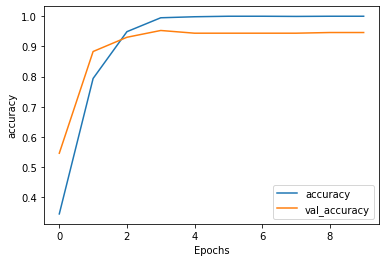

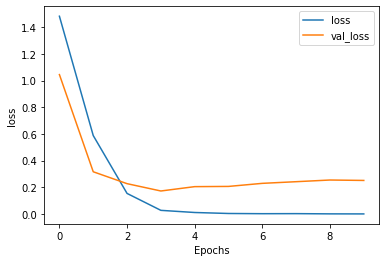

In [42]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

The model is overffiting very fast and although validation accuracy seems to improve we need to check with real cases how does it perform.

## Model 3 - Covid1D + Pooling + Glove 100d

In previous models, we started with an embedding layer of random vectors and learned the appropriate structure in the context of our task (news classification). Now we will use a vector learned in the context of a different task. 

This approach can be helpful if we have little training data, and that's the core of what we are trying to validate with this project: that we can get good results without investing in a big labeling project. 

In this case, we will use Glove as our pre-trained word vector, and the 100 dimension file (glove.6B.100d.txt) 

We hypothesize that even if the vectors are not directly related to our task, it can improve our model, adding an extensive collection of words and semantic relationships. 

We keep trainable as False and maintain the rest of the model parameters equal. 



In [43]:
# first we import and process the glove file and check number of word vectors
import os
GLOVE_DIR = 'data/glove/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [0]:
# TensorFlow must receive the embedding as a marix that we process here
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [73]:
# Model Definition with Conv1D
CONV1D_GLOVE_100 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable = False ),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2)),
    tf.keras.layers.Dense(6, activation='softmax')
])
CONV1D_GLOVE_100.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
CONV1D_GLOVE_100.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 600)               1029600   
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 3606      
Total params: 2,725,334
Trainable params: 1,225,334
Non-trainable params: 1,500,000
_________________________________________________________________


In [75]:
CONV1D_GLOVE_100.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = CONV1D_GLOVE_100.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 0.4931 - accuracy: 0.8157 - val_loss: 0.1465 - val_accuracy: 0.9551
Epoch 2/10
56/56 - 1s - loss: 0.0923 - accuracy: 0.9697 - val_loss: 0.1021 - val_accuracy: 0.9618
Epoch 3/10
56/56 - 1s - loss: 0.0679 - accuracy: 0.9753 - val_loss: 0.1083 - val_accuracy: 0.9708
Epoch 4/10
56/56 - 1s - loss: 0.0474 - accuracy: 0.9871 - val_loss: 0.1280 - val_accuracy: 0.9640
Epoch 5/10
56/56 - 1s - loss: 0.0249 - accuracy: 0.9927 - val_loss: 0.1039 - val_accuracy: 0.9685
Epoch 6/10
56/56 - 1s - loss: 0.0069 - accuracy: 0.9994 - val_loss: 0.0915 - val_accuracy: 0.9775
Epoch 7/10
56/56 - 1s - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.1353 - val_accuracy: 0.9663
Epoch 8/10
56/56 - 1s - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.1054 - val_accuracy: 0.9685
Epoch 9/10
56/56 - 1s - loss: 5.0607e-04 - accuracy: 1.0000 - val_loss: 0.1177 - val_accuracy: 0.9730
Epoch 10/10
56/56 - 1s - loss: 2.5248e-04 - accuracy: 1.0000 - val_loss: 0.1204 - val_accuracy: 0.9730


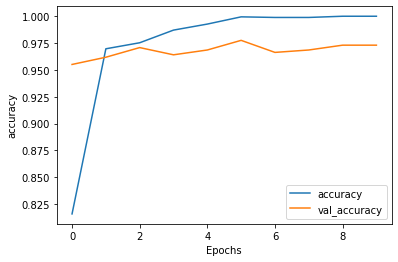

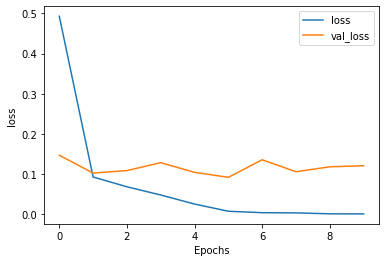

In [76]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


Overffting seems to adjust, and accuracy levels remain high.

## Model 4 - Covid1D + Pooling + Glove 300d

For our last model, we recover our LSTM structure but try with a more sophisticated word vector that now has 300 dimensions

In [48]:
#same process as with previous model, we change the glove file
GLOVE_DIR = 'data/glove/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [0]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [50]:
CONV1D_GLOVE_300 = tf.keras.Sequential([
tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],trainable = False ),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.2)),
    tf.keras.layers.Dense(6, activation='softmax')
])
CONV1D_GLOVE_300 .summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         192128    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1029600   
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 3606      
Total params: 2,725,334
Trainable params: 1,225,334
Non-trainable params: 1,500,000
_________________________________________________________________


In [51]:
CONV1D_GLOVE_300  .compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = CONV1D_GLOVE_300 .fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
56/56 - 2s - loss: 0.4566 - accuracy: 0.8320 - val_loss: 0.2173 - val_accuracy: 0.9303
Epoch 2/10
56/56 - 1s - loss: 0.0970 - accuracy: 0.9691 - val_loss: 0.1071 - val_accuracy: 0.9640
Epoch 3/10
56/56 - 1s - loss: 0.0513 - accuracy: 0.9837 - val_loss: 0.1114 - val_accuracy: 0.9730
Epoch 4/10
56/56 - 1s - loss: 0.0276 - accuracy: 0.9933 - val_loss: 0.1075 - val_accuracy: 0.9708
Epoch 5/10
56/56 - 1s - loss: 0.0133 - accuracy: 0.9966 - val_loss: 0.1187 - val_accuracy: 0.9685
Epoch 6/10
56/56 - 1s - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.1246 - val_accuracy: 0.9708
Epoch 7/10
56/56 - 1s - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.1238 - val_accuracy: 0.9730
Epoch 8/10
56/56 - 1s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.1910 - val_accuracy: 0.9685
Epoch 9/10
56/56 - 1s - loss: 0.0148 - accuracy: 0.9949 - val_loss: 0.1331 - val_accuracy: 0.9596
Epoch 10/10
56/56 - 1s - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.1291 - val_accuracy: 0.9708


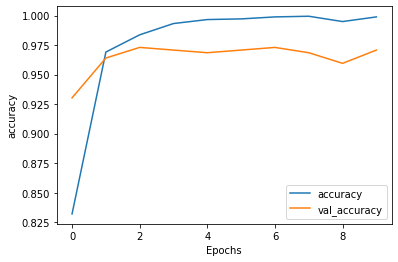

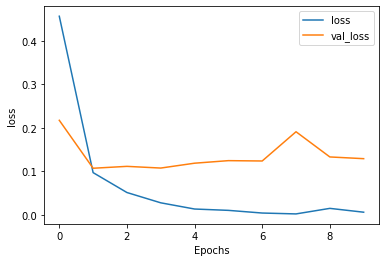

In [52]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Validation accuracy starts higher that training. Maybe it has to do with the distribution of our training and validation data. As we are using dropout to train samples but not when doing validation, if the cases are simple for the model, it can produce such a graph. 

## Step 6. Benchmark

Now is time to try our models over real data. All our models present a validation accuracy over 90% as the company asked for, but we want to check how each one performs on some real examples.
Trying to provide long and short texts, we have prepared some simple functions that retrieve tweets and headlines and selected some articles for the exercise. 

In [0]:
#get_prediction receives a text and a selected model as input 
#and returns the label for the predicted class with the highest probability calculated by the model  
def get_prediction(text):
  models = [LSTM, CONV1D, CONV1D_GLOVE_100, CONV1D_GLOVE_300]
  model_names = ['LSTM', 'CONV1D', 'CONV1D_GLOVE_100', 'CONV1D_GLOVE_300']
  for i in range(0,len(models)):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=max_length)
    pred = np.argmax(models[i].predict(padded),axis=-1)
    labels = {'business': 2, 'entertainment': 5, 'politics': 3, 'sport': 1, 'tech': 4}
    prediction =  ([k for k,v in labels.items() if v == pred])
    print ("Model-{} | {}:{}".format(str(i+1),model_names[i], prediction))

In [81]:
text1 = [
"T-Mobile may have only closed its Sprint merger earlier this month, \
but the carrier isn't letting the coronavirus put its plans on hold. \
After announcing its first deployment of the newly acquired midband spectrum \
in Philadelphia on April 1, T-Mobile plans to redeploy the airwaves in parts \
of New York in May as part of the latest expansion of its 5G network. In turning \
on the 2.5GHz spectrum in New York, T-Mobile will have its first \
city that can showcase its 5G vision. The carrier turned on higher-frequency \
millimeter-wave 5G in parts of the city last summer before adding its low-band, \
wider-reaching 5G network nationwide last December. \
On Tuesday T-Mobile will also expand the low-band footprint to include the Detroit,\
St. Louis and Columbus areas.\
Whereas the millimeter-wave network has fast download speeds but severely \
limited outdoor coverage, and the low-band much better coverage but not noticeably improved \
speeds compared with 4G LTE, the midband spectrum allows for a combination of both with \
significantly faster speeds compared to 4G on service that works both indoors and outside."
]
get_prediction(text1)

Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['tech']
Model-3 | CONV1D_GLOVE_100:['tech']
Model-4 | CONV1D_GLOVE_300:['tech']


In [80]:
text2 =["Software  as a service companies, modern software firms often referred to by the acronym 'SaaS,' \
had a tough day in the public markets. The basket of companies, as tracked by Bessemer\’s cloud index,\
dropped 4.49% during regular trading hours.\
The losses gave back some of the software industry’s recent gains,\
advances that had followed a sharp decline in the value of their shares\
as concerns relating to a COVID-19-induced economy hit the richly valued cohort of companies hard;\
indeed, at one point earlier in the year, SaaS and cloud companies were down around 38% from the 2020 highs.\
Those losses, however, largely proved transitory. A steep rally in SaaS and cloud shares brought their decline\
from all-time highs (set earlier this year) to just about 10% yesterday afternoon. Then, today,\
the firms lost over 4%. This puts SaaS and cloud shares in between a correction and a bear market."
]
get_prediction(text2)

Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['business']
Model-3 | CONV1D_GLOVE_100:['business']
Model-4 | CONV1D_GLOVE_300:['business']


In [79]:
text3 = ["(CNN)World No. 1 Rafa Nadal got his Australian Open campaign off to\
a winning start as he cruised past Bolivian Hugo Dellien 6-2 6-3 6-0. Nadal, whose sole title\
in Melbourne came in 2009, was tested by the No. 73 despite what the one-sided scoreline suggests. He was twice\
broken by Dellien -- at the end of the first set and midway through the second -- but powered through\
the third to love, wrapping up the win in just over two hours.\
Nadal led Spain to the final of the inaugural ATP Cup earlier this month, where he was defeated by Novak Djokovic in a singles match-up in the final.\
Dellien, the first Bolivian to compete at the Australian Open, had just broken inside the top 250\
in the world rankings this time two years ago; two years before that he was just inside the top 500."
]
get_prediction(text3)

Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['sport']
Model-4 | CONV1D_GLOVE_300:['sport']


Results are good in all samples for models 2-4. Model 1 (without convolutions and not using Glove) seems to have some problems to classify correctly in some samples.  


## 6.1 Twitter samples

Let's use Twitter API to get some samples coming from accounts that publish headlines (newspaper accounts), so we can get new samples quickly.

In [0]:
import tweepy
import numpy as np
 


auth = tweepy.OAuthHandler('U8iFHCD4Y4ZdBFwCVU5ltmJkt', 'XkqkPvQfSCLiAvFDG1fXxxBBS5dQITzzmyuyfORS5JlrXu3CuU')
auth.set_access_token('8138652-Gfhn0PRVSNtt6qoegaLBbICu3oYi69kn0ooMztaBFq', 'HiwXT2dzOUMGo57VQH7V9aiGylcV3HsRukz4DjqU6TD9Y')

api = tweepy.API(auth)

def get_tweets(name, nun_ofTweets):
  # Calling the user_timeline function with our parameters
  results = api.user_timeline(id=name, count=nun_ofTweets)
  # create an array with results
  tweets =[]
  for tweet in results:
   # printing the text stored inside the tweet object
    tweets.append(tweet.text)
  tweets = np.array(tweets)
  for i in range(nun_ofTweets):
    print(tweets[i])
    print("-"*90)
    get_prediction([tweets[i]])
    print("-"*90)
   

In [82]:
get_tweets('guardiantech', 20)

The schoolboy brothers making coronavirus visors for care workers https://t.co/s5zB0H0HMn
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['politics']
Model-4 | CONV1D_GLOVE_300:['tech']
------------------------------------------------------------------------------------------
Best noise-cancelling headphones for working from home https://t.co/vX2NUewAPT
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['tech']
Model-4 | CONV1D_GLOVE_300:['tech']
------------------------------------------------------------------------------------------
Sony told to pay BBC £5m for stock damaged in London riots https://t.co/hLWvwqizIK
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertai

Again models 3 and 4  seems to be more accurate with model 4 differing sometimes.




## 6.2 News headlines samples
Let's try now with the samples recorded in this new [dataset](https://www.kaggle.com/adammcmurchie/news-headlines-summary-from-select-12-sources) used for other machine learning tasks, that contains examples of news titles (and the complete text) We can play with our models, asking them to predict over documents they haven't seen before.

In [0]:
dataset = pd.read_csv('data/headlines.csv', sep=",")

In [0]:
selection = dataset['title'][100:110]

In [0]:
headlines = np.array(selection)

In [86]:
for i in range(10):
  print(headlines[i])
  print("-"*90)
  get_prediction([headlines[i]])
  print("-"*90)

Kansas officer resigned over alleged bogus complaint against McDonald's workers
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['politics']
Model-4 | CONV1D_GLOVE_300:['politics']
------------------------------------------------------------------------------------------
Facebook's latest takedown has a twist -- AI-generated profile pictures
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['tech']
Model-4 | CONV1D_GLOVE_300:['tech']
------------------------------------------------------------------------------------------
16-year-old rock climber survives 500-foot fall on Oregon's Mount Hood
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:

Now that we are stressing our models, you can see that all of them make mistakes in some cases. Remember: best validation accuracy (for model 3) is 97%, and here we are testing over random samples. The overall accuracy is what counts, but we wanted to make a little demo so the business owners can see a more practical application of the project.
It seems like Glove embedding has an outstanding impact on the final results but not necessarily in the 300d version. This version tends to classify correctly but using a more broad label (if no making mistakes)

For example, the headline:

`Facebook's latest takedown has a twist -- AI-generated profile pictures.`

It is not correctly classified by models 1 and 2 and classified as a business by model 4. One can say that 'business is correct' but less precise as 'tech' witch is the class assigned by model 3.

## 6.3 Drift in accuracy 

No matter how accurate your model is, you will need to monitor its accuracy over time and pay attention to changes in the way real data evolves. Sometimes a fundamental change in the problem you are working on may change the distribution of your data, so [your model is no as accurate anymore.](https://towardsdatascience.com/concept-drift-and-model-decay-in-machine-learning-a98a809ea8d4)

Just see how with headlines from the Google News service (not recorded headlines in a data set), our models encounter more problems to classify the information correctly.

If the paper is talking about Covid-19 or mentioning the impact of the lockdown in whatever the news category (sport, business, tech), the models defer more between one ad other, as our model was trained without those references. In some cases, a well-performing model got it absolutely wrong. 

I think this is  an excellent example of the importance of monitoring your models in production

In [90]:
import bs4
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen

news_url="https://news.google.com/news/rss"
Client=urlopen(news_url)
xml_page=Client.read()
Client.close()

soup_page=soup(xml_page,"xml")
news_list=soup_page.findAll("item")
news_titles =[]
for news in news_list:
  title = news.title.text
  news_titles.append(title)

news_titles = np.array(news_titles)
for i in range(len(news_titles)):
  print(news_titles[i])
  print("-"*90)
  get_prediction([news_titles[i]])
  print("-"*90)

Here's how Trump and his allies are trying to defend his crazy claim about injecting disinfectant - Salon
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['politics']
Model-4 | CONV1D_GLOVE_300:['politics']
------------------------------------------------------------------------------------------
Kim Jong Un Remains Absent on Day North Korean Media Celebrates Founding of Armed Forces - Newsweek
------------------------------------------------------------------------------------------
Model-1 | LSTM:['entertainment']
Model-2 | CONV1D:['sport']
Model-3 | CONV1D_GLOVE_100:['tech']
Model-4 | CONV1D_GLOVE_300:['tech']
------------------------------------------------------------------------------------------
New evidence surfaces in Tara Reade allegation against Biden - POLITICO
--------------------------------------------------------------------------------------

## 7. Recomendations


Combining model architectures with proven success in text classification with pre-trained word-embeddings seems to be good enough to approach our project tasks with the minimum accuracy expected by our stakeholders. 

Even considering the small number of samples used in the training data set,  and the generic classes used in the ground truth provided, the sum of LSTMs, convolutions, and Glove, produced the desired result. 

We recommend continuing with a more elaborated implementation, using at list the architecture defined by models 3 and 4. 
Some manual labeling would be needed though, but we suggest to put our focus on: 
- Keep the dataset balanced between cases 
- Design more concrete, more relevant labels 
- Produce a similar number of cases for training and validation
- Combine the training dataset with pre-trained embeddings 

